In [1]:
!pip install knockknock #For sending message to telegram
!pip install -q efficientnet

     |████████████████████████████████| 480 kB 970 kB/s eta 0:00:01
     |████████████████████████████████| 455 kB 2.8 MB/s eta 0:00:01
     |████████████████████████████████| 45 kB 1.4 MB/s eta 0:00:01
     |████████████████████████████████| 405 kB 3.2 MB/s eta 0:00:01
     |████████████████████████████████| 58 kB 1.9 MB/s eta 0:00:01
  Created wheel for premailer: filename=premailer-3.8.0-py2.py3-none-any.whl size=19290 sha256=714dc17ceb6d60ddafa874da2dd5c0ea58069f942bca85c74dabe3846bc9f6ff
  Stored in directory: /root/.cache/pip/wheels/e2/c8/86/b09eb808c95f4275b367cbf5dc07fc82ae48d56ad6db5d59b9
  Created wheel for twilio: filename=twilio-6.58.0-py2.py3-none-any.whl size=1267711 sha256=8f5eb9a7c849b1c018cf21b32a4e4c14066831c9eb79d1bcecb21c858facdbe7
  Stored in directory: /root/.cache/pip/wheels/a9/64/44/233579537f0969ce9149fab02e8afd8a15b23d442d51e791c9
Successfully built premailer twilio
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 

In [3]:
import os
import cv2
import math
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,precision_score,recall_score,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold
from transformers import get_cosine_schedule_with_warmup
from albumentations import *
from kaggle_datasets import KaggleDatasets

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras import optimizers
import efficientnet.tfkeras as efn
from albumentations import *


from knockknock import telegram_sender 
from kaggle_secrets import UserSecretsClient
#user_secrets = UserSecretsClient()
#token = user_secrets.get_secret("token")
#chat_id = user_secrets.get_secret("chat_id")

import warnings  
warnings.filterwarnings('ignore')

In [4]:
AUTO = tf.data.experimental.AUTOTUNE

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()
    
print("REPLICAS: ", strategy.num_replicas_in_sync)

GCS_DS_PATH = KaggleDatasets().get_gcs_path()

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [5]:
SEED = 42
BATCH_SIZE = 8 * strategy.num_replicas_in_sync
SIZE = [800,800]
LR = 0.0008
WEIGHT_DECAY = 0
EPOCHS = 40
WARMUP = 15
TTA = 4

In [6]:
def seed_everything(SEED):
    np.random.seed(SEED)
    tf.random.set_seed(SEED)

seed_everything(SEED)

In [7]:
DIR_INPUT = '/kaggle/input/plant-pathology-2020-fgvc7'
train_df = pd.read_csv(DIR_INPUT + '/train.csv')
test_df = pd.read_csv(DIR_INPUT + '/test.csv')
cols = list(train_df.columns[1:])

In [8]:
train,valid = train_test_split(train_df,test_size = 0.2,random_state = SEED)

In [9]:
transform = {
    'train' :Compose([
        Resize(SIZE[0],SIZE[1],always_apply=True),
        HorizontalFlip(p=0.5),
        VerticalFlip(p=0.5),
        RandomRotate90(p=0.5),
        Rotate(limit=25.0,p=0.8)]) }

def preprocess(df,test=False):
    paths = df.image_id.apply(lambda x: GCS_DS_PATH + '/images/' + x + '.jpg').values
    labels = df.loc[:,'healthy':].values
    if test==False:
        return paths,labels
    else:
        return paths
    
def decode_image(filename, label=None, image_size=(SIZE[0], SIZE[1])):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3) 
    image = tf.image.resize(image, image_size)
    image = tf.cast(image, tf.float32)
    image = tf.image.per_image_standardization(image)
    if label is None:
        return image
    else:
        return image, label
    
def data_augment(image, label=None, seed=SEED):
    image = tf.image.rot90(image,k=np.random.randint(4))
    image = tf.image.random_flip_left_right(image, seed=seed)
    image = tf.image.random_flip_up_down(image, seed=seed)
    if label is None:
        return image
    else:
        return image, label
    
def albu(image):
    transforms = transform['train']
    image = transforms(image=image.numpy())['image']
    image = tf.cast(image, tf.float32)
    return image
    
def albu_fn(image,label=None):
    [image,] = tf.py_function(albu, [image], [tf.float32])
    if label is None:
        return image
    else:
        return image, label

In [10]:
train_dataset = (tf.data.Dataset
    .from_tensor_slices(preprocess(train))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(data_augment, num_parallel_calls=AUTO)
    .shuffle(SEED)
    .batch(BATCH_SIZE,drop_remainder=True)
    .repeat()
    .prefetch(AUTO))

valid_dataset = (tf.data.Dataset
    .from_tensor_slices(preprocess(valid))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO))

test_dataset = (tf.data.Dataset
    .from_tensor_slices(preprocess(test_df,test=True))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE))

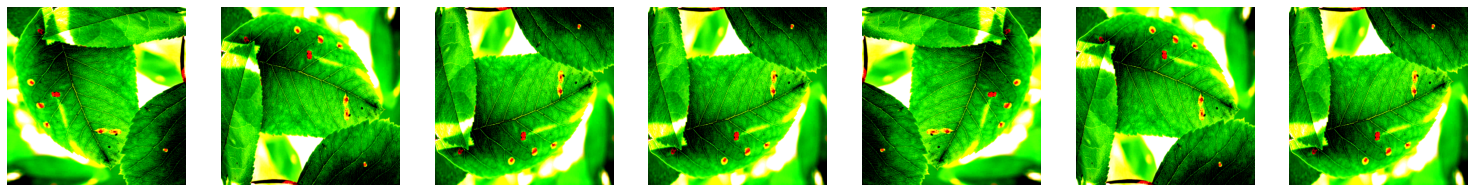

In [11]:
def plot_transform(image_id,num_images=7):
    plt.figure(figsize=(30,10))
    path,_ = preprocess(train.iloc[image_id:image_id+1])
    for i in range(1,num_images+1):
        plt.subplot(1,num_images+1,i)
        plt.axis('off')
        image = decode_image(filename=path[0])
        image = data_augment(image=image)
        plt.imshow(image)

plot_transform(9)

In [12]:
with strategy.scope():
    model = tf.keras.Sequential([
        efn.EfficientNetB7(input_shape=(SIZE[0], SIZE[1], 3),weights='imagenet',pooling='avg',include_top=False),
        Dense(4, activation='softmax')
    ])
        
    model.compile(
        optimizer='adam',
        loss = 'categorical_crossentropy',
        metrics=['categorical_accuracy'])

258441216/258434480 [==============================] - 5s 0us/step


In [13]:
def get_cosine_schedule_with_warmup(lr,num_warmup_steps, num_training_steps, num_cycles=0.5):
    """
    Modified the get_cosine_schedule_with_warmup from huggingface for tenserflow
    (https://huggingface.co/transformers/_modules/transformers/optimization.html#get_cosine_schedule_with_warmup)

    Create a schedule with a learning rate that decreases following the
    values of the cosine function between 0 and `pi * cycles` after a warmup
    period during which it increases linearly between 0 and 1.
    """

    def lrfn(epoch):
        if epoch < num_warmup_steps:
            return float(epoch) / float(max(1, num_warmup_steps)) * lr
        progress = float(epoch - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr

    return tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

lr_schedule= get_cosine_schedule_with_warmup(lr=LR,num_warmup_steps=WARMUP,num_training_steps=EPOCHS)

In [16]:
STEPS_PER_EPOCH = train.shape[0] // BATCH_SIZE
#@telegram_sender(token=token, chat_id=int(chat_id))
def train():
    history = model.fit(
        train_dataset, 
        epochs=EPOCHS, 
        callbacks=[lr_schedule],
        steps_per_epoch=STEPS_PER_EPOCH,
        validation_data=valid_dataset)
    
    string = 'Train acc:{:.4f} Train loss:{:.4f},Val acc:{:.4f} Val loss:{:.4f}'.format( \
        model.history.history['categorical_accuracy'][-1],model.history.history['loss'][-1],\
        model.history.history['val_categorical_accuracy'][-1],model.history.history['val_loss'][-1])
    
    return string

In [17]:
train()

Epoch 1/40

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0.
22/22 [==============================] - 261s 4s/step - loss: 1.3937 - categorical_accuracy: 0.2025 - val_loss: 1.6526 - val_categorical_accuracy: 0.0603
Epoch 2/40

Epoch 00002: LearningRateScheduler reducing learning rate to 5.333333333333333e-05.
22/22 [==============================] - 25s 1s/step - loss: 1.2915 - categorical_accuracy: 0.4219 - val_loss: 1.2299 - val_categorical_accuracy: 0.3973
Epoch 3/40

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00010666666666666667.
22/22 [==============================] - 33s 2s/step - loss: 0.7220 - categorical_accuracy: 0.7866 - val_loss: 0.9587 - val_categorical_accuracy: 0.7315
Epoch 4/40

Epoch 00004: LearningRateScheduler reducing learning rate to 0.00016.
22/22 [==============================] - 32s 1s/step - loss: 0.3561 - categorical_accuracy: 0.8886 - val_loss: 0.4650 - val_categorical_accuracy: 0.8849
Epoch 5/40

Epoch 00005: LearningR

'Train acc:0.9993 Train loss:0.0035,Val acc:0.9616 Val loss:0.1633'

In [18]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(15,15), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

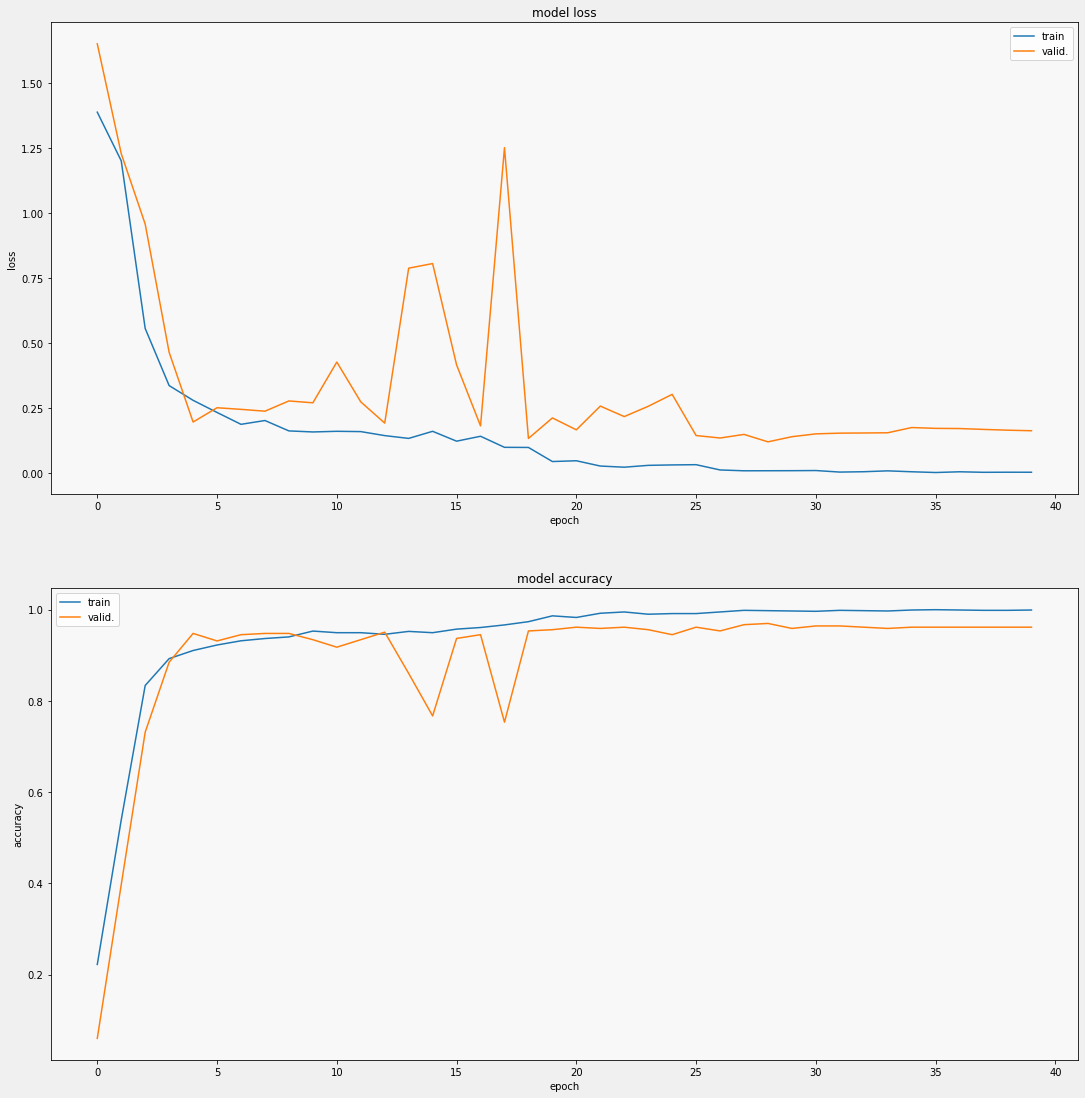

In [19]:
display_training_curves(
    model.history.history['loss'], 
    model.history.history['val_loss'], 
    'loss', 211)
display_training_curves(
    model.history.history['categorical_accuracy'], 
    model.history.history['val_categorical_accuracy'], 
    'accuracy', 212)

In [20]:
test_pred = model.predict(test_dataset, verbose=1)
submission_df = pd.read_csv(DIR_INPUT + '/sample_submission.csv')
submission_df[['healthy', 'multiple_diseases', 'rust', 'scab']] = test_pred
submission_df.to_csv('submission.csv', index=False)
pd.Series(np.argmax(submission_df[cols].values,axis=1)).value_counts()

29/29 [==============================] - 83s 3s/step


2    720
3    592
0    368
1    141
dtype: int64

In [21]:
test_pred_tta = np.zeros((len(test_df),4))
for i in range(TTA):
    test_dataset_tta = (tf.data.Dataset
    .from_tensor_slices(preprocess(test_df,test=True))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(data_augment, num_parallel_calls=AUTO)    
    .batch(BATCH_SIZE))
    test_pred_tta += model.predict(test_dataset_tta, verbose=1)
submission_df = pd.read_csv(DIR_INPUT + '/sample_submission.csv')
submission_df[['healthy', 'multiple_diseases', 'rust', 'scab']] = test_pred_tta/TTA
submission_df.to_csv('submission_tta.csv', index=False)
pd.Series(np.argmax(submission_df[cols].values,axis=1)).value_counts()

29/29 [==============================] - 46s 2s/step


2    731
3    594
0    373
1    123
dtype: int64